<a href="https://colab.research.google.com/github/pranav168/NYC-Taxi-Trip-Time-Prediction/blob/main/Copy_of_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
#Importing all the required packages and libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
!pip install haversine
import haversine as hs
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')


In [3]:
df=pd.read_csv('/content/drive/MyDrive/Copy of NYC Taxi Data.csv') 
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
df.info()                                                                       #No nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
column_list=['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration']
count_dataset=pd.DataFrame()
distinct_features=[]                                                                                          #Empty list to know the number of distict features,sum of all these values, and sum of values top 10 comprises
for i in column_list:                                                                                               
  count_dataset[i]= pd.Series(df[i].value_counts().sort_values(ascending=False).head(10).index)      
  count_dataset[f'{i}_count']=pd.Series(df[i].value_counts().sort_values(ascending=False).head(10).values).astype('int')   
  distinct_features.append((len(df[i].value_counts().index),df[i].value_counts().sum(),df[i].value_counts().sort_values(ascending=False).head(10).sum())) 
final_tally=list(zip(column_list,distinct_features))                                                           #Zipping with column_list
col_ref={}  
for i in column_list:
  if i in ['trip_duration']:                                                                    #colur red shows the Dependent Variable('trip_duration')
    col_ref[i]='background-color: red'  
  else:
    col_ref[i]='background-color: blue'                                                                       #colur blue shows the features 
  temp=f'{i}_count'
  col_ref[temp]='background-color: green'                                                                     #colur green shows the count
def Nan_as_black(val):
  if str(val)=='nan':
    color = 'black'
    return 'color: %s' % color
count_dataset=count_dataset.style.apply(lambda x: pd.DataFrame(col_ref, index=count_dataset.index, columns=count_dataset.columns).fillna(''), axis=None).highlight_null('black').applymap(Nan_as_black)
count_dataset

,id,id_count,vendor_id,vendor_id_count,pickup_datetime,pickup_datetime_count,dropoff_datetime,dropoff_datetime_count,passenger_count,passenger_count_count,pickup_longitude,pickup_longitude_count,pickup_latitude,pickup_latitude_count,dropoff_longitude,dropoff_longitude_count,dropoff_latitude,dropoff_latitude_count,store_and_fwd_flag,store_and_fwd_flag_count,trip_duration,trip_duration_count
0,id3487387,1,2.000000,780302.000000,2016-01-12 18:48:44,5,2016-02-19 19:25:04,5,1,1033540,-73.982201,633,40.774101,414,-73.982330,443,40.774311,269,N,1450599.000000,368,1624
1,id2165547,1,1.000000,678342.000000,2016-04-05 18:55:21,5,2016-05-16 19:40:28,5,2,210318,-73.982140,607,40.774090,411,-73.982094,433,40.774330,263,Y,8045.000000,408,1584
2,id1587081,1,nan,nan,2016-06-10 23:17:17,5,2016-01-08 13:00:41,4,5,78088,-73.982101,587,40.774120,410,-73.982246,430,40.750149,259,nan,nan,348,1582
3,id0385856,1,nan,nan,2016-02-09 21:03:38,5,2016-04-10 20:01:29,4,3,59896,-73.982117,585,40.774109,392,-73.982117,427,40.750118,253,nan,nan,367,1581
4,id2046043,1,nan,nan,2016-03-04 08:07:34,5,2016-01-08 12:43:38,4,6,48333,-73.982224,584,40.774078,390,-73.991379,420,40.750198,250,nan,nan,358,1577
5,id3564842,1,nan,nan,2016-05-07 13:18:07,5,2016-05-17 21:08:29,4,4,28404,-73.982094,575,40.774052,376,-73.982201,419,40.750172,247,nan,nan,399,1573
6,id1302928,1,nan,nan,2016-04-16 21:50:51,4,2016-03-18 08:01:14,4,0,60,-73.982246,558,40.774132,356,-73.982269,414,40.774319,245,nan,nan,418,1570
7,id0012117,1,nan,nan,2016-04-26 18:15:42,4,2016-02-06 19:57:23,4,7,3,-73.982208,551,40.774139,352,-73.991402,406,40.774342,244,nan,nan,417,1568
8,id3317583,1,nan,nan,2016-01-22 20:25:22,4,2016-02-18 16:10:51,4,8,1,-73.982307,546,40.774071,347,-73.982384,405,40.750038,242,nan,nan,388,1567
9,id1800370,1,nan,nan,2016-02-24 12:04:42,4,2016-03-18 14:40:49,4,9,1,-73.982239,545,40.774158,335,-73.982307,403,40.750111,242,nan,nan,344,1561


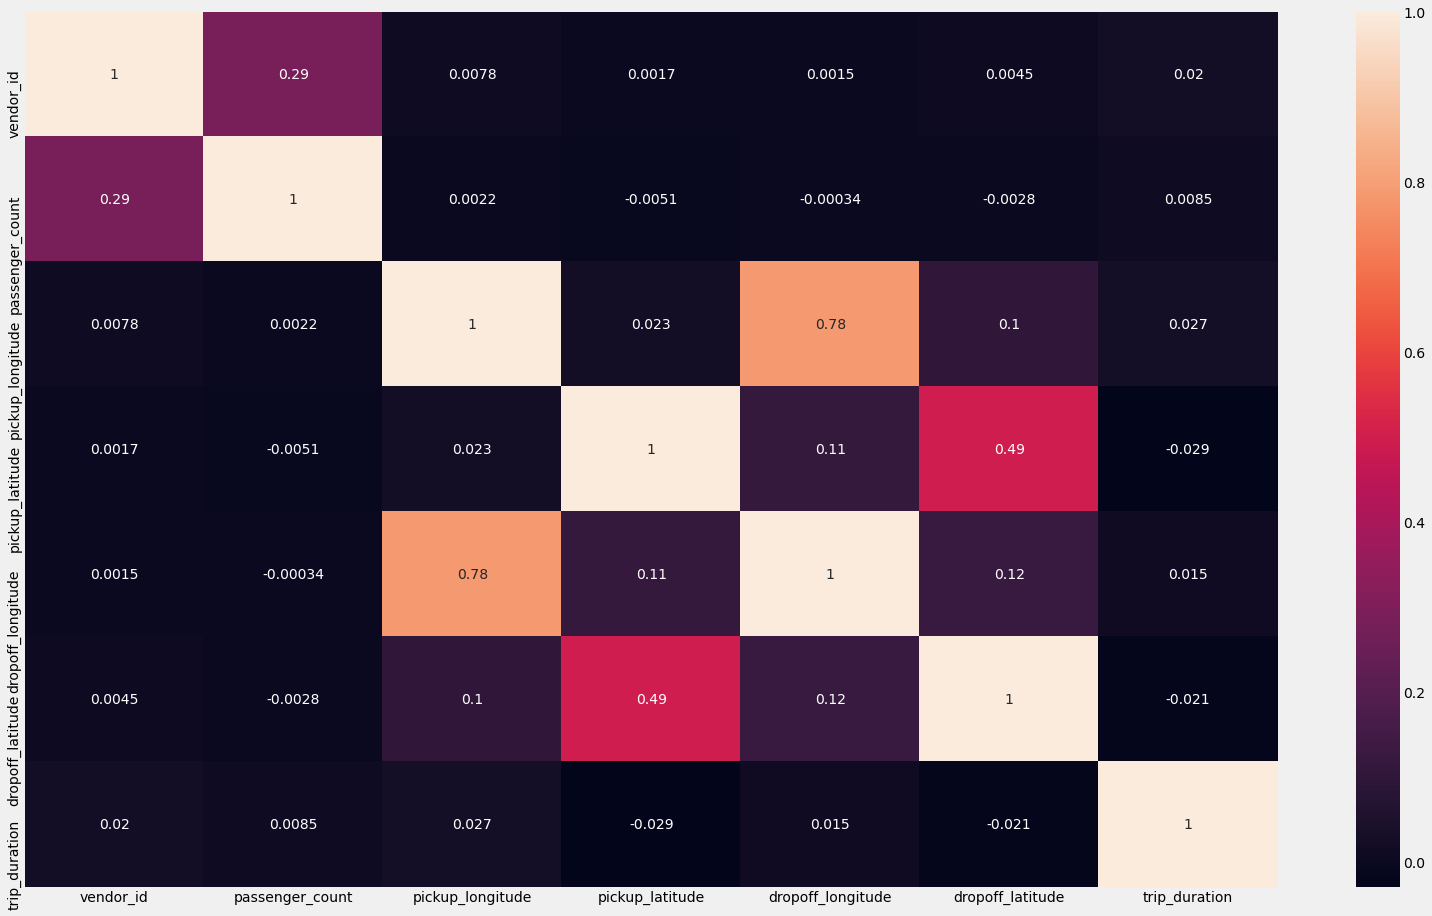

In [6]:
corr = df.corr()                                                                #plotting co-relation chart
plt.figure(figsize=(25,15))
sns.heatmap(corr, annot=True)
plt.show()                                                                      #there is no correlation whatsoever between our dependent and independent variables, thus i will be making various features to improve this situation                                            

In [7]:
df.describe()                                                                   #their are few cases with passanger count 0, lets explore it
                                                                                #also minimum drip duretion is 1 sec which show an anomaly, lets remove them first
                                                                                # Minimum pickup and dropoff longitude are really low than mean

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [8]:
df=df[df.passenger_count!=0]                                                    #Removing rows with 0 passenger count                                      

In [9]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')                 #Converting these dates to datetime format
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [10]:
print(np.percentile(df.trip_duration,0.1),
np.percentile(df.trip_duration,0.5),
np.percentile(df.trip_duration,1.5),                                            #after this the value starts to get saturated thus anything below 107 sec is mostly a outlier, now lets look for maximum value as well
np.percentile(df.trip_duration,2),
np.percentile(df.trip_duration,2.5),
np.percentile(df.trip_duration,3),
np.percentile(df.trip_duration,3.5))

7.0 51.0 107.0 122.0 135.0 146.0 156.0


In [11]:
print(np.percentile(df.trip_duration,98.5),
np.percentile(df.trip_duration,99),
np.percentile(df.trip_duration,99.5),                                           #after this the value starts to get increase suddenly thus anything above 4139 sec is mostly a outlier, lets remove these values
np.percentile(df.trip_duration,99.9))

3072.0 3440.0 4139.0 85127.41700000013


In [12]:
df=df[(df.trip_duration>=107) & (df.trip_duration<=4139)]

In [13]:
print(np.percentile(df.pickup_longitude,0.1),
      np.percentile(df.pickup_longitude,0.05),                                  #after this their is anomaly 
      np.percentile(df.pickup_longitude,0.01),                                                                  
      np.percentile(df.pickup_longitude,0.001),
      np.percentile(df.pickup_longitude,0.0001))
df=df[df.pickup_longitude>-74.017]
print(np.percentile(df.dropoff_longitude,0.1),
      np.percentile(df.dropoff_longitude,0.05),
      np.percentile(df.dropoff_longitude,0.01),                                  #after this their is anomaly                                 
      np.percentile(df.dropoff_longitude,0.001),
      np.percentile(df.dropoff_longitude,0.0001))
df=df[df.dropoff_longitude>=-74.467]

-74.01712036132812 -74.01737976074219 -74.07968558120727 -74.35324770942688 -103.73459467295076
-74.17746734619139 -74.18138921356203 -74.18852077331543 -74.46795725708009 -79.53859309568787


In [16]:
#adding another column with distance metric calculted using lat and long 
df['haversine distance (km)'] = df.apply(lambda x: float(hs.haversine((x['pickup_latitude'],x['pickup_longitude']),(x['dropoff_latitude'], x['dropoff_longitude']))),axis=1)
df.shape

(1427892, 12)

In [17]:
df.describe()                                                                   #Data looks Perfect now,still their can be some relative anomalies, which i will remove using isolation forest                      

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,haversine distance (km)
count,1.427892e+06,1.427892e+06,1.427892e+06,1.427892e+06,1.427892e+06,1.427892e+06,1.427892e+06,1.427892e+06
mean,1.535015e+00,1.665590e+00,-7.397380e+01,4.075116e+01,-7.397356e+01,4.075195e+01,8.335727e+02,3.427942e+00
std,4.987726e-01,1.314758e+00,4.072142e-02,3.073236e-02,3.874640e-02,3.366669e-02,6.076829e+02,4.003638e+00
min,1.000000e+00,1.000000e+00,-7.401700e+01,3.435970e+01,-7.445454e+01,3.435970e+01,1.070000e+02,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073754e+01,-7.399133e+01,4.073601e+01,4.070000e+02,1.262051e+00
50%,2.000000e+00,1.000000e+00,-7.398180e+01,4.075417e+01,-7.397979e+01,4.075456e+01,6.680000e+02,2.118257e+00
75%,2.000000e+00,2.000000e+00,-7.396762e+01,4.076834e+01,-7.396320e+01,4.076979e+01,1.075000e+03,3.887181e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.391176e+01,4.139000e+03,1.240910e+03


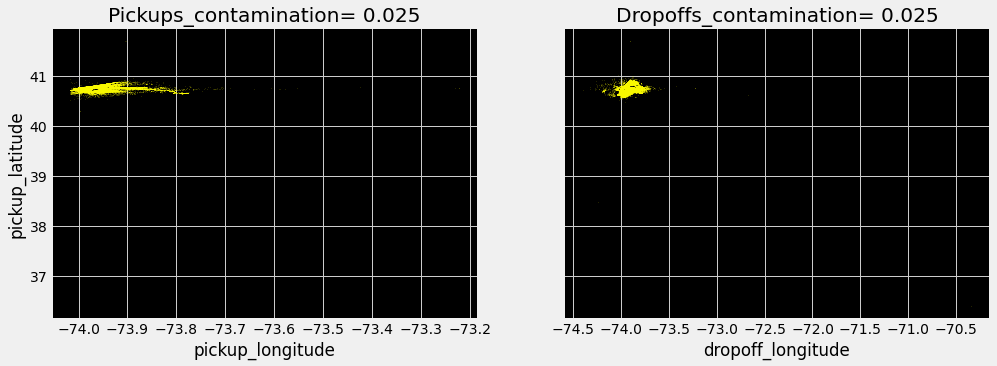

In [ ]:
minmax = MinMaxScaler(feature_range=(0, 1))                                     #Using Isolation Forest algorithm for anomaly detection, for contamination i will use various values and visualize the best scatter plot
X = minmax.fit_transform(df[['trip_duration','haversine distance (km)','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']])
contamination_list=[0.025,0.05,0.075,0.1]
for contamination in contamination_list:
  clf = IsolationForest(n_estimators=100, contamination=contamination, random_state=0)      
  try:
    clf.fit(X)
  except:
    pass
  temp=df
  temp['multivariate_outlier'] = clf.predict(X)                                   # prediction of a datapoint category outlier or inlier
  temp=temp[temp.multivariate_outlier==1]                                             #removing these outliers
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,5))

  temp.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                  color='yellow', 
                  s=.02, alpha=.6, subplots=True, ax=ax1)
  ax1.set_title(f"Pickups_contamination= {contamination}")
  ax1.set_facecolor('black')

  temp.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                  color='yellow', 
                  s=.02, alpha=.6, subplots=True, ax=ax2)
  ax2.set_title(f"Dropoffs_contamination= {contamination}")
  ax2.set_facecolor('black') 
  plt.show()

In [ ]:
'''Thus contamination=0.075 works best as we want to retain maximum amount of data'''
clf = IsolationForest(n_estimators=100, contamination=contamination, random_state=0)      
clf.fit(X)
df['multivariate_outlier'] = clf.predict(X)                                   # prediction of a datapoint category outlier or inlier
df=df[df.multivariate_outlier==1]  
df.drop('multivariate_outlier',axis=1,inplace=True)

In [ ]:
df.head()

In [ ]:
try:
  df.drop('id',axis=1,inplace=True)                                             #this is of no use
except:
  pass
sns.countplot(df.passenger_count)
one_hot_entity='Passenger_count'    
column_one_hot=['passenger_count']                # one hot encoding 
count=0

In [ ]:
for i in column_one_hot:
  temp_df=pd.get_dummies(df[i], prefix=one_hot_entity)
  count+=1
  try:
    df_one_hot=pd.concat([df_one_hot, temp_df], axis=1)
  except:
    df_one_hot=temp_df
df=pd.concat([df,df_one_hot], axis=1)
df.head()

In [ ]:
train['trip_duration_in_hour']=train['trip_duration'].apply(lambda x:x/3600)
train.head()

In [ ]:
outlier_trip_duration=train.loc[train['trip_duration_in_hour']>24]
outlier_trip_duration

In [ ]:
pickup=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
              color='blue', label='train', alpha=0.1)

fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)


In [ ]:
drop=train.groupby(['dropoff_latitude_round3','dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [ ]:
pickup=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'Avg_Trip_duration'}) #from graph there are many outliers because of longitude and some due to latitude we will remove both

In [ ]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)


hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Avg_Trip_duration.values)),
                     min_opacity=0.2,
                     radius=7, blur=15,
                     max_zoom=1 
                 )
pickup_map.add_child(hm_wide)
pickup_map

In [ ]:
avg_duration_hour=train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(),'o-')

In [ ]:
avg_duration_day=train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week',y='avg_trip_duration',data=avg_duration_day,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Trip Duration vs Pickup Days of Week")

In [ ]:
def calculateBearing(lat1,lng1,lat2,lng2):
    R = 6371 
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [ ]:
train['bearing']=train.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)

In [ ]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords)
train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
              c=train['pickup_neighbourhood'], label='train', alpha=0.1)

fig.suptitle('Pickup Neighbourhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [ ]:
train['avg_speed_kph']=train['trip_distance']/train['trip_duration_in_hour']
plt.figure(figsize=(8,5))
sns.kdeplot(train['avg_speed_kph'].values).set_title("Distribution of Average Speed (in kph)")
drop_cols=['avg_speed_kph','trip_duration_in_hour','dropoff_date','dropoff_day','dropoff_hour','dropoff_day_of_week','dropoff_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
training=train.drop(drop_cols,axis=1)


In [ ]:
training['log_trip_duration']=training['trip_duration'].apply(lambda x:np.log(x))
training.drop(['trip_duration'],axis=1,inplace=True)

In [ ]:
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]


In [ ]:
training['pickup_day_of_week']=training['pickup_day_of_week'].apply(lambda x:encodeDays(x))


In [ ]:
def LabelEncoding(train_df,test_df,max_levels=2):
    for col in train_df:
        if train_df[col].dtype == 'object':
            if len(list(train_df[col].unique())) <= max_levels:
                le = preprocessing.LabelEncoder()
                le.fit(train_df[col])
                train_df[col]=le.transform(train_df[col])
                test_df[col]=le.transform(test_df[col])
    return [train_df,test_df]
                

def readInputAndEncode(input_path,train_file,test_file,target_column):
    training=pd.read_csv(input_path+train_file)
    testing=pd.read_csv(input_path+test_file)
   
    training,testing=LabelEncoding(training,testing)
    
    #print("Training Data Shape after Encoding ",training.shape)
    #print("Testing Data Shape after Encoding ",testing.shape)
    #Check if all train columns are there in test data. If not add the column to test data and replace it with zero
    train_cols=training.columns.tolist()
    test_cols=testing.columns.tolist()
    col_in_train_not_test=set(train_cols)-set(test_cols)
    for col in col_in_train_not_test:
        if col!=target_column:
            testing[col]=0
    col_in_test_not_train=set(test_cols)-set(train_cols)
    for col in col_in_test_not_train:
        training[col]=0
    print("Training Data Shape after Processing ",training.shape)
    print("Testing Data Shape after Processing ",testing.shape)
    return [training,testing]

In [ ]:
y_pred_train=model.predict(X_train)

In [ ]:
y_pred_test=model.predict(X_test)

In [ ]:
X_test.shape

In [ ]:
r2_score(y_train,y_pred_train)

In [ ]:
r2_score(y_test,y_pred_test)

In [ ]:
# from sklearn.tree import DecisionTreeRegressor 

# # create a regressor object
# regressor = DecisionTreeRegressor(random_state = 0,max_depth=5, max_leaf_nodes=30) 
  
# # fit the regressor with X and Y data
# regressor.fit(X_train, y_train)

In [ ]:
# y_pred_train2 = regressor.predict(X_train)
# y_pred_test2=regressor.predict(X_test)
  
# print the predicted price


In [ ]:
# r2_score(y_train,y_pred_train2)

In [ ]:
# r2_score(y_test,y_pred_test2)

In [ ]:
# mean_squared_error(y_test,y_pred_test2)

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# rf.fit(X_train,y_train)


In [ ]:
# valid_pred_rf=rf.predict(X_test)
# rmse=mean_squared_error(y_test,valid_pred_rf)
# print("Root Mean Squared Error for Random Forest",rmse)

In [ ]:
test_pred=rf.predict(testing)

In [ ]:
y_train

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error

sgd_model = SGDRegressor(max_iter=1000, tol=1e-3)

In [ ]:
last_test_mae = -1

pointer = 0
for i in range(10):
    
    X_train_small = X_train[pointer*16:(pointer+1)*16].copy()
    y_train_small = y_train[pointer*16:(pointer+1)*16].copy()
    
    X_train_small = distance(X_train_small)
    
    X_train_small = hour_of_the_day(X_train_small)
    
    X_train_small = X_train_small[['hour_day', 'passenger_count', 'distance']]
    
    sgd_model.partial_fit(X_train_small, y_train_small.ravel())
        
    mae = mean_absolute_error(y_train_small, sgd_model.predict(X_train_small))

    # Test
    
    X_test_small = X_test.copy()
    y_test_small = y_test.copy()
    X_test_small = distance(X_test_small)
    X_test_small = hour_of_the_day(X_test_small)
    X_test_small = X_test_small[['hour_day', 'passenger_count', 'distance']]
    
    test_mae = mean_absolute_error(y_test_small, sgd_model.predict(X_test_small))

    print(f"iteration: {i}, mae: {mae}, test_mae: {test_mae}")
    
    if (pointer+1)*100 > len(X_train):
        pointer = 0
    
    if last_test_mae == test_mae:
        break
    else:
        last_test_mae = test_mae